In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from tensorflow.keras.utils import to_categorical

In [5]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
# Define hyperparameters (replace with the actual best hyperparameters from your tuner output)
best_embedding_dim = 64
best_lstm_units = 64
best_dropout_rate = 0.2
best_learning_rate = 0.001
MAX_LEN = 40
VOCAB_SIZE = 10000 # Use the vocabulary size from your tokenization step
BATCH_SIZE = 32
EPOCHS = 12 # Use the desired number of epochs for training the final model


In [ ]:
from google.colab import files

# Upload first file
print("Upload balanced_emotions.csv:")
uploaded1 = files.upload()

# Upload second file
print("Upload Music Info.csv:")
uploaded2 = files.upload()

Upload tweet_emotions.csv:


Upload Music Info.csv:


In [7]:
# Load the dataset
df = pd.read_csv('/content/balanced_emotions.csv')

# Clean and stem the text
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))


In [8]:
df.head()

,tweet_id,sentiment,content,clean_text,final_label
0,1694438930,hate,@emzyjonas Yea once - me and my friends flew o...,yea once me and my friends flew out to amercia...,anger
1,1957564908,sadness,My phone passed away yesterday.. He jumped off...,my phone passed away yesterday he jumped off t...,sadness
2,1693974800,happiness,"Woop, have just bought the Elliot Minor album ...",woop have just bought the elliot minor album o...,joy
3,1962109294,hate,@orbitaldiamonds That drives me nuts.,that drives me nuts,anger
4,1958135239,neutral,Barnsley To Keep Davey And Sign A New Experi...,barnsley to keep davey and sign a new experien...,neutral


In [9]:
df.shape

(74106, 5)

In [10]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)       # remove URLs
    text = re.sub(r"@\w+", "", text)          # remove mentions
    text = re.sub(r"[^a-zA-Z\s]", "", text)   # remove punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

def stem_text(text):
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(stemmed_words)


In [11]:
df['cleaned_content'] = df['content'].apply(clean_text)
df['stemmed_content'] = df['cleaned_content'].apply(stem_text)


In [12]:
# Tokenization and padding
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<UNK>")
tokenizer.fit_on_texts(df['stemmed_content'])
X = tokenizer.texts_to_sequences(df['stemmed_content'])
X = pad_sequences(X, maxlen=MAX_LEN, padding='post', truncating='post')


In [13]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['final_label'])
num_classes = len(label_encoder.classes_)
y = to_categorical(y, num_classes=num_classes)


In [14]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [15]:
# Calculate class weights
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)
class_weights = dict(enumerate(class_weights))


In [16]:
# Build the best model
model_best = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=best_embedding_dim),
    Bidirectional(LSTM(units=best_lstm_units)),
    Dropout(best_dropout_rate),
    Dense(num_classes, activation='softmax')
])

model_best.build(input_shape=(None, MAX_LEN))


In [17]:
model_best.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=best_learning_rate),
    metrics=['accuracy']
)

model_best.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 64)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 706,822 (2.70 MB)

 Trainable params: 706,822 (2.70 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the best model
history_best = model_best.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)]
)

Epoch 1/12
1853/1853 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.3954 - loss: 1.4598 - val_accuracy: 0.5927 - val_loss: 1.0713 - learning_rate: 0.0010
Epoch 2/12
1853/1853 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.6385 - loss: 0.9592 - val_accuracy: 0.6455 - val_loss: 0.9477 - learning_rate: 0.0010
Epoch 3/12
1853/1853 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.7142 - loss: 0.7879 - val_accuracy: 0.6737 - val_loss: 0.8932 - learning_rate: 0.0010
Epoch 4/12
1853/1853 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - accuracy: 0.7551 - loss: 0.6845 - val_accuracy: 0.7002 - val_loss: 0.8520 - learning_rate: 0.0010
Epoch 5/12
1853/1853 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.7902 - loss: 0.5911 - val_accuracy: 0.7185 - val_loss: 0.8315 - learning_rate: 0.0010
Epoch 6/12
1853/1853 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.8183 - loss: 0.5076 - val_accuracy: 0.7309 - val_loss: 0.8270 - learning_rate: 0.0010
Epoch 7/12
1853/1853 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accura

In [19]:
# Evaluate the best model on the validation data
loss_best, accuracy_best = model_best.evaluate(X_val, y_val)
print(f"Validation Accuracy : {accuracy_best:.4f}")

464/464 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7914 - loss: 0.9576
Validation Accuracy : 0.7898


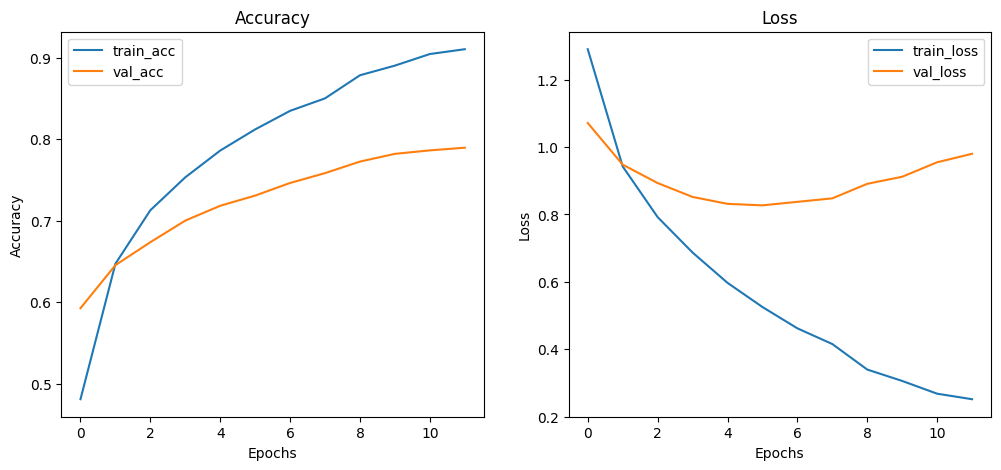

In [20]:
# Visualize training history of the best model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_best.history['accuracy'], label='train_acc')
plt.plot(history_best.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_best.history['loss'], label='train_loss')
plt.plot(history_best.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

464/464 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


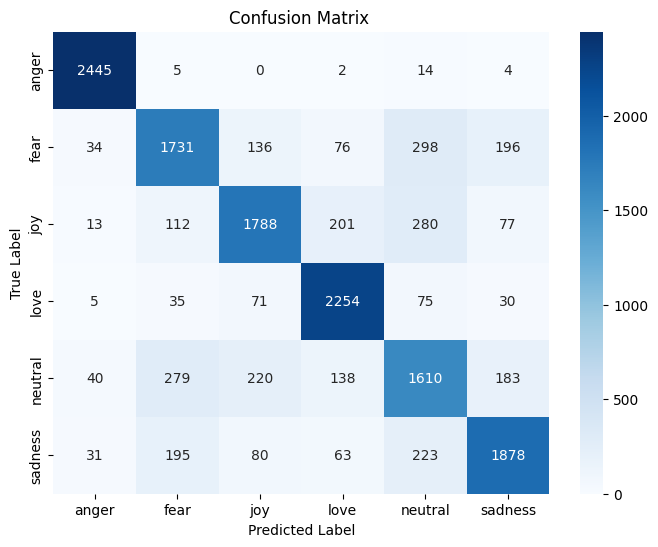

In [21]:
# Generate and plot confusion matrix for the best model
y_pred_prob_best = model_best.predict(X_val)
y_pred_best = np.argmax(y_pred_prob_best, axis=1)
y_true_best = np.argmax(y_val, axis=1)

cm_best = confusion_matrix(y_true_best, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix ')
plt.show()

In [22]:
# Save the best model
model_best.save('emotions_prediction_model.h5')
print("emotions_prediction_model saved successfully!")

emotions_prediction_model saved successfully!


# Music Recommendation system Logic

In [23]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
import os
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

# Suppress unnecessary warnings
warnings.filterwarnings("ignore", category=UserWarning)

# --- 1. CONFIGURATION AND LOADING THE SAVED MODEL ---
MODEL_PATH = 'emotions_prediction_model.h5' # Use the path where you saved your model

# Check if the model file exists
if not os.path.exists(MODEL_PATH):
    print(f"Error: Model file not found at '{MODEL_PATH}'")
    print("Please make sure you have saved the model as 'emotions_prediction_model.h5'.")
    exit()

# Load the fine-tuned model
print("Loading your saved emotion detection model...")
model = load_model(MODEL_PATH)
print("Model loaded successfully!")

Loading your saved emotion detection model...
Model loaded successfully!


In [24]:

# Define the mapping from the model's output index to the emotion label.
# IMPORTANT: This must exactly match the labels used during training.
# Assuming the labels are ['anger', 'joy', 'love', 'neutral', 'sadness', 'surprise'] based on the confusion matrix
idx_to_label = {0: 'anger', 1: 'joy', 2: 'love', 3: 'neutral', 4: 'sadness', 5: 'surprise'}


music_df = pd.read_csv('/content/Music_Info.csv')
print("Music info dataset loaded successfully.")

# Define the same preprocessing steps used during training
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)       # remove URLs
    text = re.sub(r"@\w+", "", text)          # remove mentions
    text = re.sub(r"[^a-zA-Z\s]", "", text)   # remove punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

def stem_text(text):
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(stemmed_words)

# Define the tokenizer and MAX_LEN used during training
# You need to re-initialize the tokenizer and fit it on the training data or save/load the fitted tokenizer
# For simplicity, we'll re-initialize and assume the vocabulary is the same.
# In a real application, you should save and load the fitted tokenizer.
# Based on the previous cells, VOCAB_SIZE = 10000 and MAX_LEN = 40
VOCAB_SIZE = 10000
MAX_LEN = 40
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<UNK>")
# You need access to the original training data or fitted tokenizer here to ensure correct tokenization
# For demonstration, we'll assume the tokenizer is fitted on the same data distribution
# In a real scenario, load the saved tokenizer:
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)


Music info dataset loaded successfully.


In [25]:

def recommend_songs(predicted_emotion, music_df, num_recs=5):
    """Recommends songs based on the predicted emotion."""
    # Adjust recommendation logic based on the new emotion labels
    if predicted_emotion == 'joy' or predicted_emotion == 'love' or predicted_emotion == 'surprise':
        # Recommendations for positive emotions
        recommendations = music_df[(music_df['valence'] > 0.6) & (music_df['energy'] > 0.6)]
    elif predicted_emotion == 'sadness' or predicted_emotion == 'anger':
        # Recommendations for negative emotions
        recommendations = music_df[music_df['valence'] < 0.4]
    else: # 'neutral'
        recommendations = music_df[(music_df['valence'] >= 0.4) & (music_df['valence'] <= 0.6)]

    # Fallback in case not enough songs match the criteria
    if len(recommendations) < num_recs:
        print(f"Warning: Not enough songs found for '{predicted_emotion}'. Returning random recommendations.")
        return music_df.sample(n=num_recs, replace=True)[['name', 'artist','spotify_preview_url']]
    return recommendations.sample(n=num_recs)[['name', 'artist','spotify_preview_url']]


In [26]:

# --- 3. THE PREDICTION PIPELINE ---
def get_music_recommendation(text_input, tokenizer, model, label_encoder):
    """
    Takes a text string, predicts its emotion using the loaded model,
    and returns a list of recommended songs.
    """
    # Preprocess the input text
    cleaned_text = clean_text(text_input)
    stemmed_text = stem_text(cleaned_text)

    # Tokenize and pad the input text
    seq = tokenizer.texts_to_sequences([stemmed_text])
    padded_seq = pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')

    # Get prediction from the model
    predictions = model.predict(padded_seq)
    # Get the index of the highest probability
    prediction_idx = np.argmax(predictions, axis=1)[0]

    # Convert the prediction index to the emotion string
    # Use the label_encoder to get the original label string
    predicted_emotion = label_encoder.classes_[prediction_idx]


    print(f"\n🔍 Detected Emotion: '{predicted_emotion.capitalize()}'")

    # Get song recommendations based on the predicted emotion
    song_recs = recommend_songs(predicted_emotion, music_df)

    print("\n🎧 Here are some songs you might like:")
    return song_recs

In [27]:
# This block runs when you execute the script directly
if __name__ == "__main__":
    # Re-fit the tokenizer on the data to ensure correct tokenization
    df = pd.read_csv('/content/balanced_emotions.csv')
    df['cleaned_content'] = df['content'].apply(clean_text)
    df['stemmed_content'] = df['cleaned_content'].apply(stem_text)
    tokenizer.fit_on_texts(df['stemmed_content'])

    # Re-initialize the label encoder and fit it on the data to get the correct classes
    label_encoder = LabelEncoder()
    label_encoder.fit(df['final_label'])
    print("\n" + "="*50)

In [28]:
print("\n" + "="*50)
print("🎵 Emotion-Powered Music Recommendation System 🎵")
print("="*50)
while True:
      user_input = input("\nHow are you feeling today? > ")
      if len(user_input.strip())<10:
          print("enter valid text or enter minimum 10 characters to detecting emotion")
          continue
      break
recommendations = get_music_recommendation(user_input, tokenizer, model, label_encoder)
display(recommendations)


🎵 Emotion-Powered Music Recommendation System 🎵

How are you feeling today? > today i am in bad mood
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step

🔍 Detected Emotion: 'Sadness'

🎧 Here are some songs you might like:


,name,artist,spotify_preview_url
36722,Dead Lazers,Kap Bambino,https://p.scdn.co/mp3-preview/4c37bb2405fcc73b...
42187,Do You Love Me Now,The Breeders,https://p.scdn.co/mp3-preview/6a6a7db7aca75f89...
24200,Lunch Hall Food Brawl,Municipal Waste,https://p.scdn.co/mp3-preview/3c6b49dc392dd723...
40813,When I Go Out,Little Dragon,https://p.scdn.co/mp3-preview/6305f16285d0ce7e...
22585,Nolan,Ben Frost,https://p.scdn.co/mp3-preview/f5d566210d551b6e...
